# Data Augmentation

Augment a dataset by flipping, rotating, and modifying the contrast

### Import the basics

In [ ]:
import context
from mlnowcasting.utils.utils import is_rainy_event
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.random import choice

Load the dataset

In [1]:
dataset_in  = '../data/datasets/example_dataset.npy'
dataset_out = '../data/datasets/example_dataset_augmented.npy'

data = np.load(dataset_in)
data.shape

(10, 64, 64, 64)

### Define the transformation operations to augment the dataset

In [2]:
def flip(s):
    return np.flip(s,np.random.randint(0,3))

def rotate(s):
    for i in range(np.random.randint(0,4)):
        s = np.rot90(s, axes=(2, 1))
    return s

def contrast(s):
    min, max = np.min(s), np.max(s)       
    LUT = np.zeros(256,dtype=np.uint8)
    LUT[min:max+1] = np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)
    return LUT[s]

### Plot example of transformations

Define a simple plot function to compare datasets

In [3]:
def plot(orig, augmented):
    fig = plt.figure(figsize=(30,5))
    skip = int(len(orig)/10)
    for i in range(0,10):
        plt.subplot(2,10,i+1)
        plt.imshow(orig[i*skip,...] ,vmin=0, vmax=255,cmap='gray')
        plt.axis('off')
        plt.subplot(2,10,i+11)
        plt.imshow(augmented[i*skip,...] ,vmin=0, vmax=255,cmap='gray')
        plt.axis('off')
    plt.show()

#### FLIP

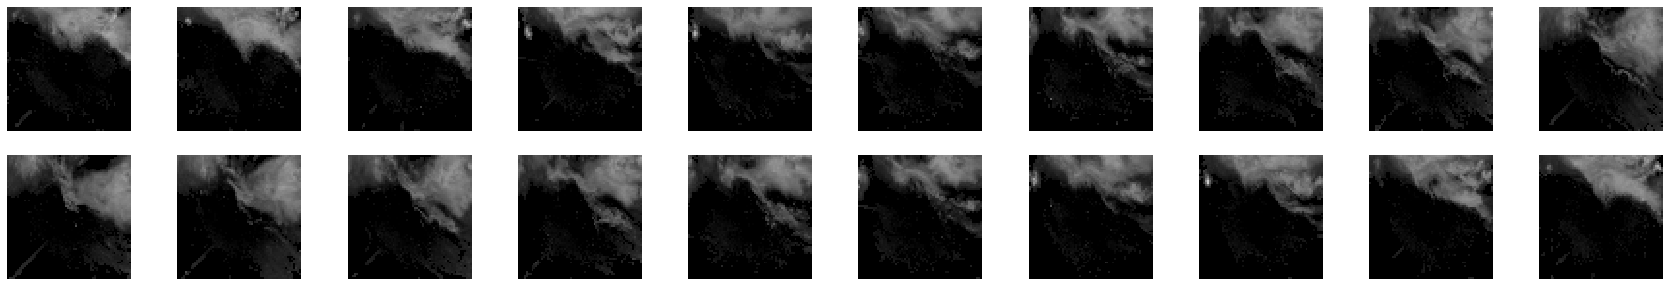

In [4]:
event = data[0]
plot(event, flip(event))

#### ROTATE

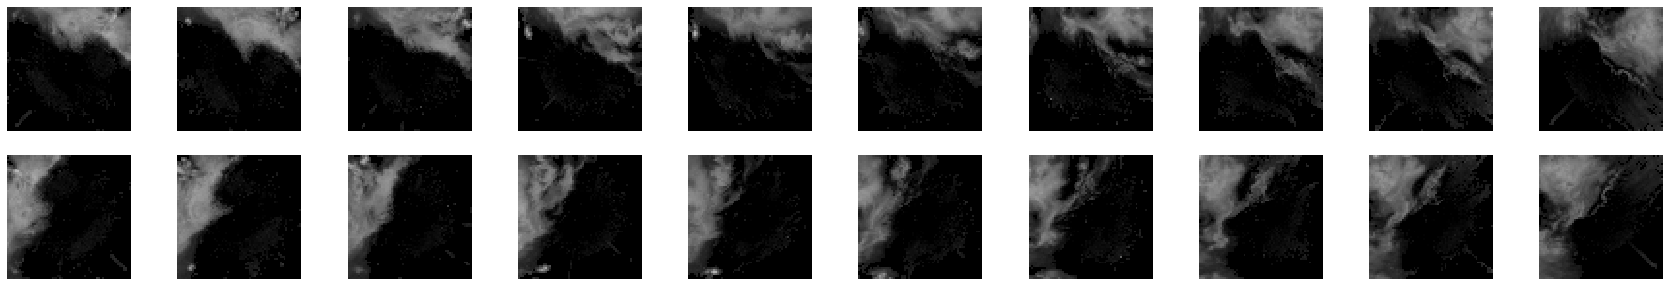

In [5]:
event = data[0]
plot(event, rotate(event))

#### CONTRAST

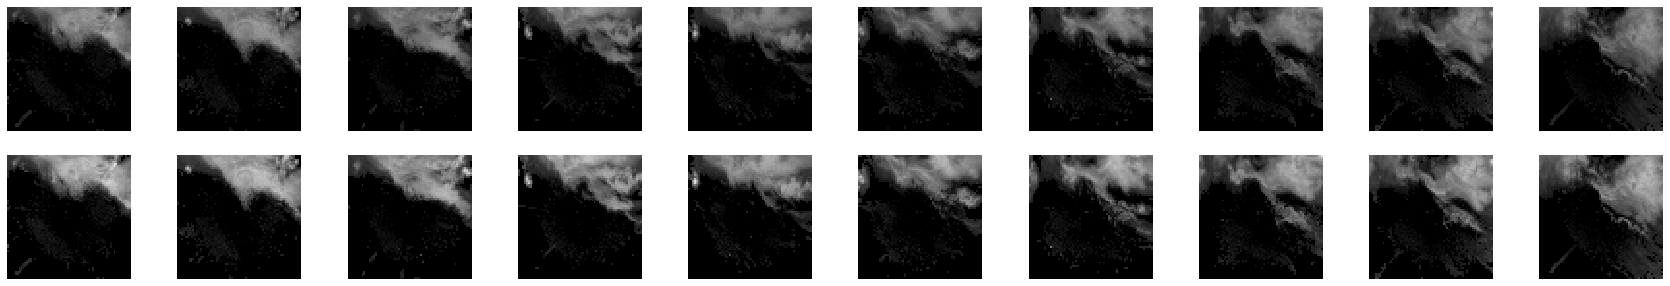

In [6]:
event = data[0]
plot(event, contrast(event))

### Auxiliar functions

Define a function to convert the scores of how rainy an event is to a probability of being used as a candidate fot transformations

First, create a histogram of the scores distributions in the dataset

In [7]:
th_dbz = 30
scores = []
for event in data:
    _, score = is_rainy_event(event/255*70, th=th_dbz, return_score=True)
    scores = np.append(scores,score[0])
#plt.hist(scores);
maxd = np.max(scores)
mind = np.min(scores)

In [8]:
def score2probability(score, maxd, mind):
    # maxd, mind should be from the distribution of scores of the training dataset
    OldRange = (maxd - mind)  
    NewRange = (0.8 - 0.2)  
    p = 1 - ((((score - mind) * NewRange) / OldRange) + 0.2)
    return 1 if p > 1 else p

### Perform the data augmentation

In [9]:
new_data = []
for event in data:
    _, score = is_rainy_event(event/255*70, th=th_dbz, return_score=True)
    p = score2probability(score[0], maxd, mind)
    if choice([False,True], 1, p=[1-p,p]): #if True , the event is going to be transformed
        if np.random.rand(1) > 0.5:
            event = flip(event)        
        if np.random.rand(1) > 0.5:
            event = contrast(event)        
        if np.random.rand(1) > 0.5:
            event = rotate(event)
        new_data.append(event)

new_data = np.array(new_data)
augmented = np.vstack((new_data, data))
np.random.shuffle(augmented)
print("old dataset's events:",len(data), ", augmented dataset's events:",len(augmented))

old dataset's events: 10 , augmented dataset's events: 16


### Save new dataset

In [10]:
np.save(dataset_out, augmented)